## Fitting Rb 87

Importing packages

In [16]:
import numpy as np 
from scipy.optimize import curve_fit
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

Importing data and plotting spectrum for 1 file

In [17]:
# ## Location of No Insulation Data
# path = 'I:/Science/Physics-Photonics/Group/Allan_OPM_MEMS_Fab_and_Clocks/PostDoc_Mainly_RbTPT/TPT_signal_data/Infleqtion_wafer/Infleqtion_Phoenix_wafer/Infleqtion_Phoenix_wafer/Abi/InsulationTest/2025-11-19-NoInsulation'

# ## Collect paths of all CSV files from folder into a list
# csv_files = glob.glob(os.path.join(path, "*.csv"))
# numb_files = len(csv_files) # The number of files

# print(csv_files)

# fileno = 10

# ## Take first file and extract data into dataframe
# df = pd.read_csv(csv_files[fileno - 1])

# ## Display data frame
# df.head()

# ## extracting time base (x) and amplitude (y) data
# ## ommiting column heading
# x = (df['x-axis'].to_numpy())[1:] 
# y = (df['1'].to_numpy())[1:]

# ## Converting data to float
# x = x.astype(float)
# y = y.astype(float)

# ## Imverting signal
# y = np.flip(y)

# # Find Peaks - adjusted params to only find 2 peaks
# p, properties = find_peaks(y, height = 0.07, distance = 5, prominence = 0.02)

# # rescale x and y axes
# ptime = np.array([p[0],p[1]])
# deltat = x[ptime[1]] - x[ptime[0]]
# deltaf = 14.412 #MHz
# # zero point is set to centre of largest peak; freq is in MHz
# freq = -(x - x[ptime[0]]) * deltaf / deltat

# # Get rid of y offset
# sig = (y - np.mean(y[0:9]))*1e3 #NB units are mV

# ## Chop data to focus on biggest peak
# sigp = sig[900:1100]
# freqp = freq[900:1100]

# ## Fitting - Loretzian dist.
# # 3 params - amplitude A, centre point C, linewidth gamma (FWHM)

# def lorentz(xdata,A,C,gamma): 
#     x1 = (xdata-C)/(gamma/2)
#     return A / (1 + x1**2)


# guess = np.array([140,0,2])

# popt,pcov = curve_fit(lorentz,freqp,sigp,p0=guess)
# perr = np.sqrt(np.diag(pcov))
# print(popt, perr)

# print('The full width half maximum is {} pm {} Mhz'.format(popt[2],perr[2]))

# ## Chi Squared

# # degrees of freedom = size of dad set - fit params
# dof = np.size(freqp) - np.size(popt) 

# # chi squared function
# def chi_squared(xdata,ydata,f,params):
#     return np.sum(((ydata - f(xdata,*params))**2) / f(xdata,*params))

# # Calculate cs and reduced cs
# cs = chi_squared(freqp,sigp,lorentz,popt)
# red_cs = cs / dof
# print('The Chi Squared is {}'.format(cs))
# print('The Reduced Chi Squared is {}'.format(red_cs))

# # Residuals
# def residuals(xdata,ydata,f,params):
#     return (ydata - f(xdata,*params))

# resd = residuals(freqp,sigp,lorentz,popt)

# # Plotting
# fig, (ax1,ax2) = plt.subplots(2,1, height_ratios = [4,1], sharex='all')

# ax1.set_title('Lineshape of file {} - Uninsulated PMT'.format(fileno))
# ax1.scatter(freqp,sigp, s = 1)
# ax1.plot(freqp,lorentz(freqp,*popt))
# ax2.set_xlabel('\n Frequency / MHz')
# ax1.set_ylabel('Voltage / mV \n')
# ax1.grid(True)
# ax2.grid(True)

# ax2.scatter(freqp,resd,s=1)
# ax2.set_ylabel('Residuals / mV \n')


Analysing and plotting data for N number of files

[1.56925256e+02 7.25261586e-02 1.29513817e+00] [1.78731202 0.0073743  0.02087196]
The full width half maximum of file 1 is 1.2951381658123924 pm 0.020871960058756744 Mhz
The Chi Squared is 287.7483707091236
The Reduced Chi Squared is 1.4606516279650945
[153.39743196  -1.09355538   1.09360338] [1.14028843 0.00406426 0.01150041]
The full width half maximum of file 2 is 1.0936033764503692 pm 0.011500413879784085 Mhz
The Chi Squared is 135.1378625178251
The Reduced Chi Squared is 0.6859789975524118
[153.5810561   -1.55036865  -1.12432739] [1.71253606 0.0062677  0.01773663]
The full width half maximum of file 3 is -1.1243273899380208 pm 0.017736631732042554 Mhz
The Chi Squared is 243.88715396578687
The Reduced Chi Squared is 1.2380058576943496
[153.54696716  -1.41636826   1.1503944 ] [1.68703399 0.00631907 0.01788214]
The full width half maximum of file 4 is 1.1503943952237528 pm 0.017882135030070783 Mhz
The Chi Squared is 148.18094365059142
The Reduced Chi Squared is 0.7521875312212762
[15

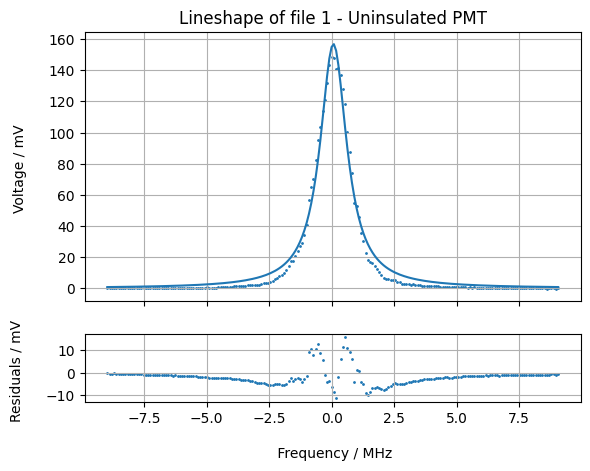

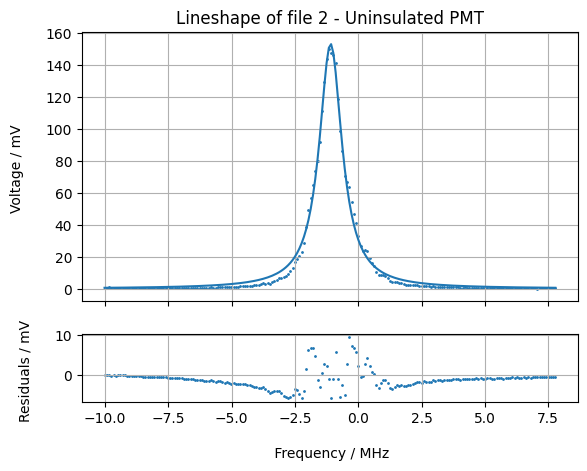

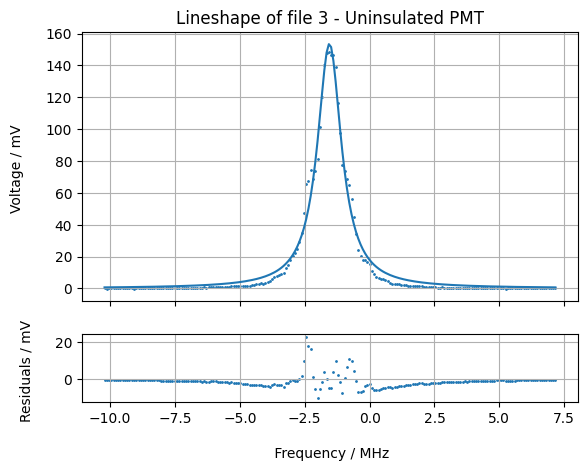

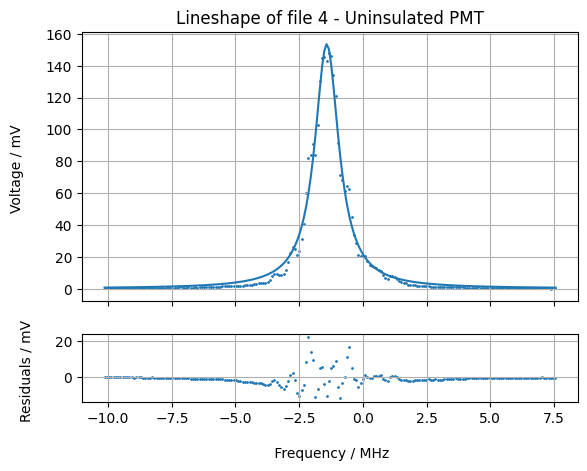

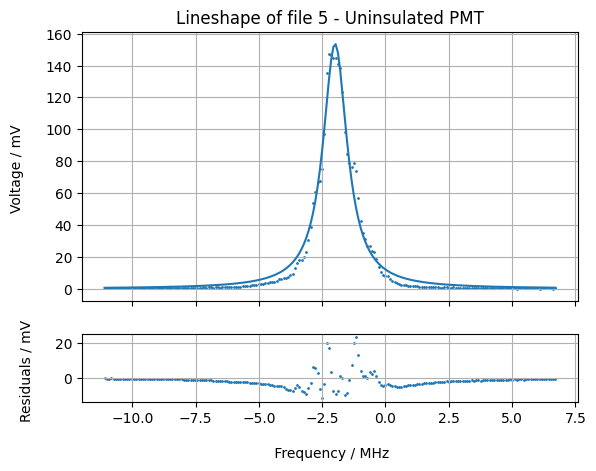

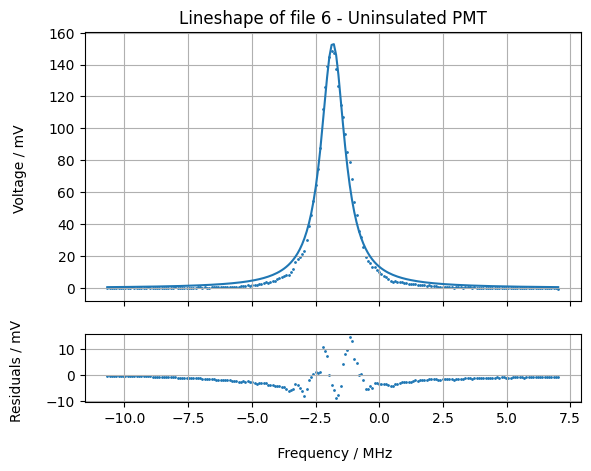

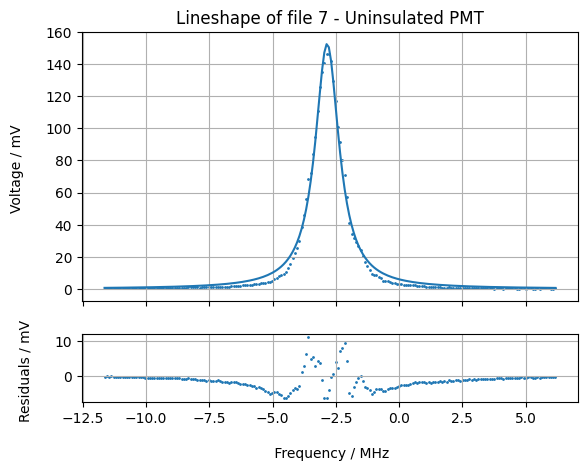

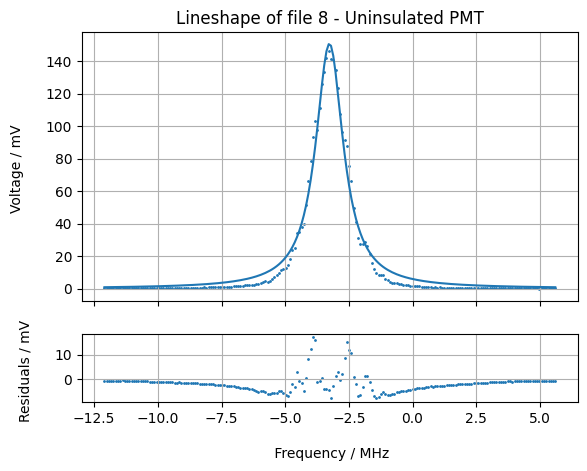

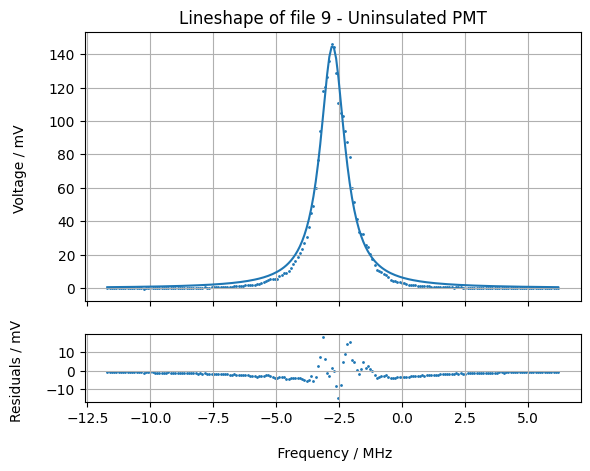

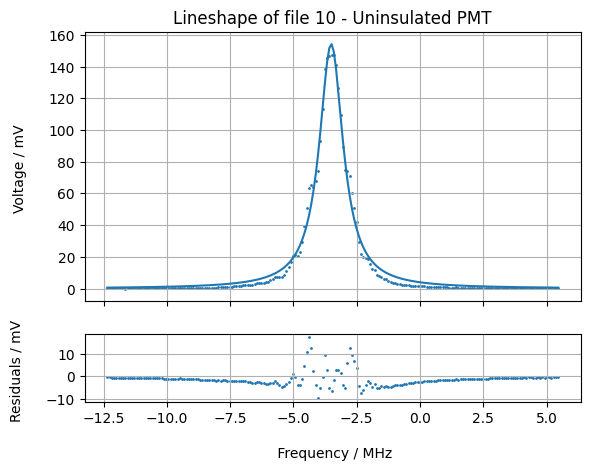

In [18]:
## Location of No Insulation Data
path = 'I:/Science/Physics-Photonics/Group/Allan_OPM_MEMS_Fab_and_Clocks/PostDoc_Mainly_RbTPT/TPT_signal_data/Infleqtion_wafer/Infleqtion_Phoenix_wafer/Infleqtion_Phoenix_wafer/Abi/InsulationTest/2025-11-19-NoInsulation'

## Collect paths of all CSV files from folder into a list
csv_files = glob.glob(os.path.join(path, "*.csv"))
numb_files = len(csv_files) # The number of files

# Saving all important quantities into empty arrays
ref = np.zeros(numb_files)
fwhm = np.zeros(numb_files)
fwhmerr = np.zeros(numb_files)
cs_arr = np.zeros(numb_files)
rcs_arr = np.zeros(numb_files)

for i in range(numb_files):

    ## Take a file and extract data into dataframe
    df = pd.read_csv(csv_files[i])

    ## Display data frame
    df.head()

    ## extracting time base (x) and amplitude (y) data
    ## ommiting column heading
    x = (df['x-axis'].to_numpy())[1:] 
    y = (df['1'].to_numpy())[1:]

    ## Converting data to float
    x = x.astype(float)
    y = y.astype(float)

    ## Inverting signal
    y = np.flip(y)

    # Find Peaks - adjusted params to only find 2 peaks
    p, properties = find_peaks(y, height = 0.07, distance = 5, prominence = 0.02)

    # rescale x and y axes
    ptime = np.array([p[0],p[1]])
    deltat = x[ptime[1]] - x[ptime[0]]
    deltaf = 14.412 #MHz

    # Want x axis referenced from the first set of data - save all ref points then only use first one
    ref[i] = x[ptime[0]]

    # zero point is set to centre of largest peak of first data set; freq is in MHz
    freq = -(x - ref[0]) * deltaf / deltat

    # Get rid of y offset
    sig = (y - np.mean(y[0:9]))*1e3 #NB units are mV

    ## Chop data to focus on biggest peak - modify for each data set with ptime[0]
    first = ptime[0]-100
    last = ptime[0]+100
    sigp = sig[first:last]
    freqp = freq[first:last]

    ## Fitting - Loretzian dist.
    # 3 params - amplitude A, centre point C, linewidth gamma (FWHM)

    def lorentz(xdata,A,C,gamma): 
        x1 = (xdata-C)/(gamma/2)
        return A / (1 + x1**2)

    guess = np.array([140,0,2])

    popt,pcov = curve_fit(lorentz,freqp,sigp,p0=guess)
    perr = np.sqrt(np.diag(pcov))
    print(popt, perr)

    ## Save fwhm and errs into arrays
    fwhm[i] = popt[2]
    fwhmerr[i] = perr[2]

    print('The full width half maximum of file {} is {} pm {} Mhz'.format(i+1,popt[2],perr[2]))

    ## Chi Squared

    # degrees of freedom = size of dad set - fit params
    dof = np.size(freqp) - np.size(popt) 

    # chi squared function
    def chi_squared(xdata,ydata,f,params):
        return np.sum(((ydata - f(xdata,*params))**2) / f(xdata,*params))

    # Calculate cs and reduced cs
    cs = chi_squared(freqp,sigp,lorentz,popt)
    red_cs = cs / dof
    print('The Chi Squared is {}'.format(cs))
    print('The Reduced Chi Squared is {}'.format(red_cs))

    ## Save chi squareds
    cs_arr[i] = cs
    rcs_arr[i] = red_cs

    # Residuals
    def residuals(xdata,ydata,f,params):
        return (ydata - f(xdata,*params))

    resd = residuals(freqp,sigp,lorentz,popt)

    # Plotting
    fig, (ax1,ax2) = plt.subplots(2,1, height_ratios = [4,1], sharex='all')

    ax1.set_title('Lineshape of file {} - Uninsulated PMT'.format(i+1))
    ax1.scatter(freqp,sigp, s = 1)
    ax1.plot(freqp,lorentz(freqp,*popt))
    ax2.set_xlabel('\n Frequency / MHz')
    ax1.set_ylabel('Voltage / mV \n')
    ax1.grid(True)
    ax2.grid(True)

    ax2.scatter(freqp,resd,s=1)
    ax2.set_ylabel('Residuals / mV \n')